# Lagos Flood Prediction Analysis

In [125]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

## Data Import and Preprocessing

In [126]:
df = pd.read_csv('lagos_weeather_data_2002_to_2024.csv')
df_target = pd.read_excel('Flood event.xlsx')

In [127]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations,windspeedmax,windspeedmin
0,Lagos,2002-01-01,28.6,25.6,27.2,33.8,25.6,30.7,25.2,88.7,...,NaN,2002-01-01T06:57:21,2002-01-01T18:42:38,0.57,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,65201099999,NaN,NaN
1,Lagos,2002-01-02,33.1,26.1,29.0,39.4,26.1,33.8,25.1,80.5,...,NaN,2002-01-02T06:57:46,2002-01-02T18:43:08,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,65201099999,NaN,NaN
2,Lagos,2002-01-03,34.1,25.1,29.1,35.2,25.1,31.7,23.2,74.6,...,NaN,2002-01-03T06:58:11,2002-01-03T18:43:39,0.64,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,65201099999,NaN,NaN
3,Lagos,2002-01-04,33.1,33.1,33.1,39.4,39.4,39.4,24.1,59.3,...,NaN,2002-01-04T06:58:35,2002-01-04T18:44:10,0.68,Partially cloudy,Becoming cloudy in the afternoon.,partly-cloudy-day,65201099999,NaN,NaN
4,Lagos,2002-01-05,31.1,25.6,28.3,37.4,25.6,33.1,25.4,85.0,...,NaN,2002-01-05T06:58:59,2002-01-05T18:44:40,0.71,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,65201099999,NaN,NaN


In [128]:
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)[:11]

windspeedmin      0.957815
windspeedmax      0.957815
severerisk        0.843015
preciptype        0.569387
snowdepth         0.547833
snow              0.547257
uvindex           0.378976
solarradiation    0.378976
solarenergy       0.378976
windgust          0.322729
winddir           0.139004
dtype: float64

In [129]:
df.drop(columns=['preciptype', 'snow', 'snowdepth', 'windgust', 'solarenergy', 'uvindex', 'solarradiation', 'windspeedmax', 'windspeedmin', 'severerisk', 'winddir'], inplace=True)

In [130]:
df.dropna(inplace=True)

In [131]:
df.shape

(7176, 24)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7176 entries, 0 to 8675
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              7176 non-null   object 
 1   datetime          7176 non-null   object 
 2   tempmax           7176 non-null   float64
 3   tempmin           7176 non-null   float64
 4   temp              7176 non-null   float64
 5   feelslikemax      7176 non-null   float64
 6   feelslikemin      7176 non-null   float64
 7   feelslike         7176 non-null   float64
 8   dew               7176 non-null   float64
 9   humidity          7176 non-null   float64
 10  precip            7176 non-null   float64
 11  precipprob        7176 non-null   float64
 12  precipcover       7176 non-null   float64
 13  windspeed         7176 non-null   float64
 14  sealevelpressure  7176 non-null   float64
 15  cloudcover        7176 non-null   float64
 16  visibility        7176 non-null   float64
 17  

In [133]:
df['name'].unique()

array(['Lagos', 'lagos'], dtype=object)

In [134]:
df.conditions.unique()

array(['Partially cloudy', 'Rain, Partially cloudy', 'Overcast',
       'Rain, Overcast', 'Clear', 'Rain'], dtype=object)

In [135]:
df.description.unique()[:10]

array(['Clearing in the afternoon.', 'Partly cloudy throughout the day.',
       'Becoming cloudy in the afternoon.',
       'Partly cloudy throughout the day with a chance of rain throughout the day.',
       'Becoming cloudy in the afternoon with rain.',
       'Cloudy skies throughout the day.',
       'Clearing in the afternoon with morning rain.',
       'Becoming cloudy in the afternoon with late afternoon rain.',
       'Becoming cloudy in the afternoon with afternoon rain.',
       'Partly cloudy throughout the day with late afternoon rain.'],
      dtype=object)

In [136]:
df.icon.unique()

array(['partly-cloudy-day', 'rain', 'cloudy', 'wind', 'fog', 'clear-day'],
      dtype=object)

In [137]:
df.stations.unique()[:10]

array(['65201099999', '65205099999,65201099999',
       '65202099999,65201099999', '65201099999.0',
       '65210099999,65201099999', '65210099999,DNMM,65201099999',
       '65210099999,DNMM,remote,65201099999', 'DNMM,65201099999',
       'DNMM,remote,65201099999', 'remote,65201099999'], dtype=object)

In [138]:
df.drop(columns=['stations', 'icon', 'description', 'name'], inplace=True)

In [139]:
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,sealevelpressure,cloudcover,visibility,sunrise,sunset,moonphase,conditions
0,2002-01-01,28.6,25.6,27.2,33.8,25.6,30.7,25.2,88.7,0.0,0.0,0.0,16.6,1010.9,90.0,6.5,2002-01-01T06:57:21,2002-01-01T18:42:38,0.57,Partially cloudy
1,2002-01-02,33.1,26.1,29.0,39.4,26.1,33.8,25.1,80.5,0.0,0.0,0.0,18.4,1011.2,90.0,8.4,2002-01-02T06:57:46,2002-01-02T18:43:08,0.61,Partially cloudy
2,2002-01-03,34.1,25.1,29.1,35.2,25.1,31.7,23.2,74.6,0.0,0.0,0.0,18.4,1011.7,90.0,4.9,2002-01-03T06:58:11,2002-01-03T18:43:39,0.64,Partially cloudy
3,2002-01-04,33.1,33.1,33.1,39.4,39.4,39.4,24.1,59.3,0.0,0.0,0.0,14.8,1010.2,90.0,8.0,2002-01-04T06:58:35,2002-01-04T18:44:10,0.68,Partially cloudy
4,2002-01-05,31.1,25.6,28.3,37.4,25.6,33.1,25.4,85.0,0.0,0.0,0.0,20.5,1010.0,90.0,5.3,2002-01-05T06:58:59,2002-01-05T18:44:40,0.71,Partially cloudy


In [140]:
time_col = ['datetime', 'sunrise', 'sunset']

for col in time_col:
    df[col] = pd.to_datetime(df[col], format='mixed')

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7176 entries, 0 to 8675
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          7176 non-null   datetime64[ns]
 1   tempmax           7176 non-null   float64       
 2   tempmin           7176 non-null   float64       
 3   temp              7176 non-null   float64       
 4   feelslikemax      7176 non-null   float64       
 5   feelslikemin      7176 non-null   float64       
 6   feelslike         7176 non-null   float64       
 7   dew               7176 non-null   float64       
 8   humidity          7176 non-null   float64       
 9   precip            7176 non-null   float64       
 10  precipprob        7176 non-null   float64       
 11  precipcover       7176 non-null   float64       
 12  windspeed         7176 non-null   float64       
 13  sealevelpressure  7176 non-null   float64       
 14  cloudcover        7176 non-nu

### Basic Statistics and Data Overview

In [142]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,7176,2014-12-05 05:20:52.173913088,2002-01-01 00:00:00,2009-06-05 18:00:00,2015-09-26 12:00:00,2020-10-30 06:00:00,2024-12-03 00:00:00,NaN
tempmax,7176.0,31.372269,23.1,29.375,31.7,33.1,56.0,2.567605
tempmin,7176.0,24.412333,9.1,23.2,24.2,25.4,33.4,1.893165
temp,7176.0,27.466931,22.3,26.2,27.4,28.7,34.3,1.595813
feelslikemax,7176.0,37.353972,23.1,34.1,37.8,40.6,56.0,4.549213
feelslikemin,7176.0,24.859169,5.8,23.2,24.2,25.4,42.5,2.930064
feelslike,7176.0,30.424889,22.3,27.5,30.2,33.0,42.5,3.518239
dew,7176.0,23.985033,8.2,23.5,24.3,25.0,66.5,1.952011
humidity,7176.0,82.596628,33.8,80.1,83.5,86.8,100.0,7.371005
precip,7176.0,5.108124,0.0,0.0,0.0,1.9,299.0,18.449482


In [143]:
encoder = LabelEncoder()
df['conditions'] = encoder.fit_transform(df['conditions'])

In [144]:
df['day_duration'] = (df['sunrise'] - df['sunset']).dt.seconds / 3600

In [145]:
df.drop(columns=['sunrise', 'sunset'], inplace=True)

In [146]:
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,sealevelpressure,cloudcover,visibility,moonphase,conditions,day_duration
0,2002-01-01,28.6,25.6,27.2,33.8,25.6,30.7,25.2,88.7,0.0,0.0,0.0,16.6,1010.9,90.0,6.5,0.57,2,12.245278
1,2002-01-02,33.1,26.1,29.0,39.4,26.1,33.8,25.1,80.5,0.0,0.0,0.0,18.4,1011.2,90.0,8.4,0.61,2,12.243889
2,2002-01-03,34.1,25.1,29.1,35.2,25.1,31.7,23.2,74.6,0.0,0.0,0.0,18.4,1011.7,90.0,4.9,0.64,2,12.242222
3,2002-01-04,33.1,33.1,33.1,39.4,39.4,39.4,24.1,59.3,0.0,0.0,0.0,14.8,1010.2,90.0,8.0,0.68,2,12.240278
4,2002-01-05,31.1,25.6,28.3,37.4,25.6,33.1,25.4,85.0,0.0,0.0,0.0,20.5,1010.0,90.0,5.3,0.71,2,12.238611


In [147]:
df = df.set_index('datetime')

In [148]:
def transform_to_monthly(df):    
    agg_functions = {col: 'mean' for col in df.columns if col not in ['sunrise', 'sunset']}
    df = df.resample('M').agg(agg_functions)
    return df

In [149]:
df = transform_to_monthly(df)

In [150]:
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,sealevelpressure,cloudcover,visibility,moonphase,conditions,day_duration
datetime,,,,,,,,,,,,,,,,,,
2002-01-31,31.467742,24.296774,27.516129,34.277419,24.500000,29.583871,21.058065,71.090323,0.048387,3.225806,0.268710,21.212903,1011.370968,89.964516,4.190323,0.474194,2.096774,12.206478
2002-02-28,29.750000,26.825000,28.100000,34.818750,29.243750,32.125000,24.437500,82.193750,2.493750,6.250000,0.260625,21.381250,1009.962500,88.437500,6.912500,0.400625,2.187500,12.079983
2002-03-31,31.054545,27.781818,29.336364,37.550000,32.077273,34.995455,25.418182,80.350000,0.000000,0.000000,0.000000,21.950000,1009.281818,90.000000,8.663636,0.480000,2.000000,11.907033
2002-04-30,30.282609,26.591304,28.326087,36.565217,29.204348,32.843478,25.169565,83.847826,0.030435,4.347826,0.181304,20.295652,1008.786957,90.108696,9.039130,0.396957,2.086957,11.724420
2002-05-31,30.396000,25.704000,28.104000,36.976000,27.440000,32.396000,25.228000,85.176000,0.208000,16.000000,0.667200,19.324000,1010.468000,89.268000,8.532000,0.552000,2.440000,11.589678


In [151]:
df.shape

(276, 18)

In [152]:
df_target.head()

,Year,Month,Event,Impact Areas
0,2009,July,Flood,"Lagos island, Ikoyi, VI, Lekki"
1,2009,October,Flood,"Surulere, Lagos island, Ikorodu"
2,2010,June,Flood,Ijagemo and environs
3,2010,July,Flood,"Surulere, Lagos island, VI"
4,2010,August,Flood,"Ajegunle, Mushin, Ajah"


In [153]:
df['Year'] = df.index.year
df['Month'] = df.index.month

In [154]:
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,sealevelpressure,cloudcover,visibility,moonphase,conditions,day_duration,Year,Month
datetime,,,,,,,,,,,,,,,,,,,,
2002-01-31,31.467742,24.296774,27.516129,34.277419,24.500000,29.583871,21.058065,71.090323,0.048387,3.225806,0.268710,21.212903,1011.370968,89.964516,4.190323,0.474194,2.096774,12.206478,2002,1
2002-02-28,29.750000,26.825000,28.100000,34.818750,29.243750,32.125000,24.437500,82.193750,2.493750,6.250000,0.260625,21.381250,1009.962500,88.437500,6.912500,0.400625,2.187500,12.079983,2002,2
2002-03-31,31.054545,27.781818,29.336364,37.550000,32.077273,34.995455,25.418182,80.350000,0.000000,0.000000,0.000000,21.950000,1009.281818,90.000000,8.663636,0.480000,2.000000,11.907033,2002,3
2002-04-30,30.282609,26.591304,28.326087,36.565217,29.204348,32.843478,25.169565,83.847826,0.030435,4.347826,0.181304,20.295652,1008.786957,90.108696,9.039130,0.396957,2.086957,11.724420,2002,4
2002-05-31,30.396000,25.704000,28.104000,36.976000,27.440000,32.396000,25.228000,85.176000,0.208000,16.000000,0.667200,19.324000,1010.468000,89.268000,8.532000,0.552000,2.440000,11.589678,2002,5


In [155]:
df_target['Month'] = pd.to_datetime(df_target['Month'], format='%B').dt.month

In [156]:
df_target.head()

,Year,Month,Event,Impact Areas
0,2009,7,Flood,"Lagos island, Ikoyi, VI, Lekki"
1,2009,10,Flood,"Surulere, Lagos island, Ikorodu"
2,2010,6,Flood,Ijagemo and environs
3,2010,7,Flood,"Surulere, Lagos island, VI"
4,2010,8,Flood,"Ajegunle, Mushin, Ajah"


In [157]:
df.shape

(276, 20)

In [158]:
df_target.shape

(28, 4)

In [159]:
df = pd.merge(df, df_target, on=['Year', 'Month'], how='left').set_index(df.index)

In [160]:
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,sealevelpressure,cloudcover,visibility,moonphase,conditions,day_duration,Year,Month,Event,Impact Areas
datetime,,,,,,,,,,,,,,,,,,,,,
2002-01-31,31.467742,24.296774,27.516129,34.277419,24.500000,29.583871,21.058065,71.090323,0.048387,3.225806,...,1011.370968,89.964516,4.190323,0.474194,2.096774,12.206478,2002,1,NaN,NaN
2002-02-28,29.750000,26.825000,28.100000,34.818750,29.243750,32.125000,24.437500,82.193750,2.493750,6.250000,...,1009.962500,88.437500,6.912500,0.400625,2.187500,12.079983,2002,2,NaN,NaN
2002-03-31,31.054545,27.781818,29.336364,37.550000,32.077273,34.995455,25.418182,80.350000,0.000000,0.000000,...,1009.281818,90.000000,8.663636,0.480000,2.000000,11.907033,2002,3,NaN,NaN
2002-04-30,30.282609,26.591304,28.326087,36.565217,29.204348,32.843478,25.169565,83.847826,0.030435,4.347826,...,1008.786957,90.108696,9.039130,0.396957,2.086957,11.724420,2002,4,NaN,NaN
2002-05-31,30.396000,25.704000,28.104000,36.976000,27.440000,32.396000,25.228000,85.176000,0.208000,16.000000,...,1010.468000,89.268000,8.532000,0.552000,2.440000,11.589678,2002,5,NaN,NaN


In [161]:
df.shape

(276, 22)

In [162]:
df.drop(columns=['Year', 'Month', 'Impact Areas'], inplace=True)

In [163]:
df.Event.fillna('not flood', inplace=True)

In [164]:
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,sealevelpressure,cloudcover,visibility,moonphase,conditions,day_duration,Event
datetime,,,,,,,,,,,,,,,,,,,
2002-01-31,31.467742,24.296774,27.516129,34.277419,24.500000,29.583871,21.058065,71.090323,0.048387,3.225806,0.268710,21.212903,1011.370968,89.964516,4.190323,0.474194,2.096774,12.206478,not flood
2002-02-28,29.750000,26.825000,28.100000,34.818750,29.243750,32.125000,24.437500,82.193750,2.493750,6.250000,0.260625,21.381250,1009.962500,88.437500,6.912500,0.400625,2.187500,12.079983,not flood
2002-03-31,31.054545,27.781818,29.336364,37.550000,32.077273,34.995455,25.418182,80.350000,0.000000,0.000000,0.000000,21.950000,1009.281818,90.000000,8.663636,0.480000,2.000000,11.907033,not flood
2002-04-30,30.282609,26.591304,28.326087,36.565217,29.204348,32.843478,25.169565,83.847826,0.030435,4.347826,0.181304,20.295652,1008.786957,90.108696,9.039130,0.396957,2.086957,11.724420,not flood
2002-05-31,30.396000,25.704000,28.104000,36.976000,27.440000,32.396000,25.228000,85.176000,0.208000,16.000000,0.667200,19.324000,1010.468000,89.268000,8.532000,0.552000,2.440000,11.589678,not flood


In [165]:
df['Event'] = encoder.fit_transform(df['Event'])

In [166]:
df.fillna(df.mean(), inplace=True)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2002-01-31 to 2024-12-31
Freq: ME
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           276 non-null    float64
 1   tempmin           276 non-null    float64
 2   temp              276 non-null    float64
 3   feelslikemax      276 non-null    float64
 4   feelslikemin      276 non-null    float64
 5   feelslike         276 non-null    float64
 6   dew               276 non-null    float64
 7   humidity          276 non-null    float64
 8   precip            276 non-null    float64
 9   precipprob        276 non-null    float64
 10  precipcover       276 non-null    float64
 11  windspeed         276 non-null    float64
 12  sealevelpressure  276 non-null    float64
 13  cloudcover        276 non-null    float64
 14  visibility        276 non-null    float64
 15  moonphase         276 non-null    float64
 16  conditions      

### Visualizations

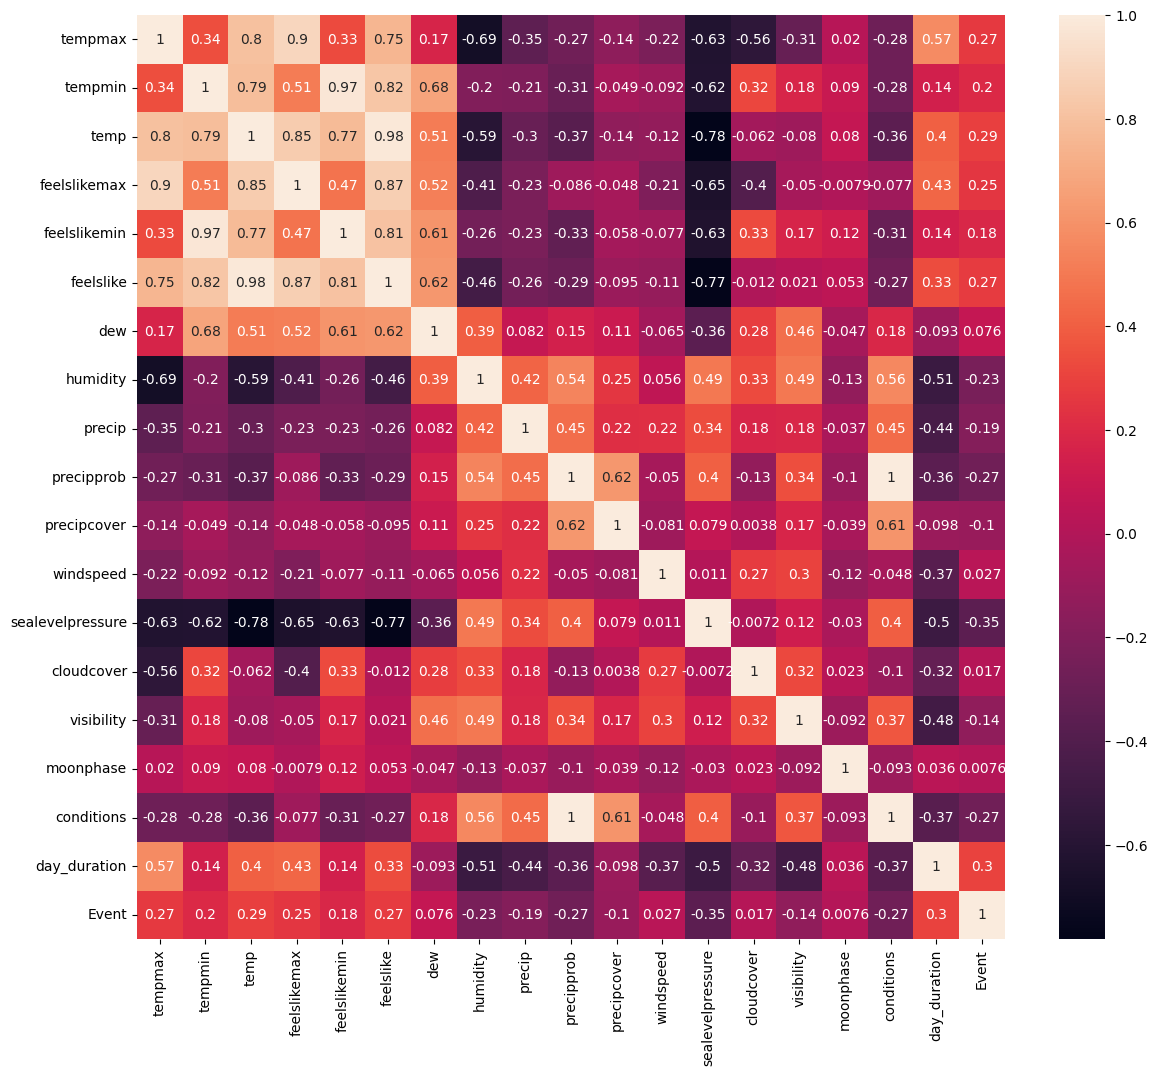

In [168]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.select_dtypes('number').corr(), annot=True);

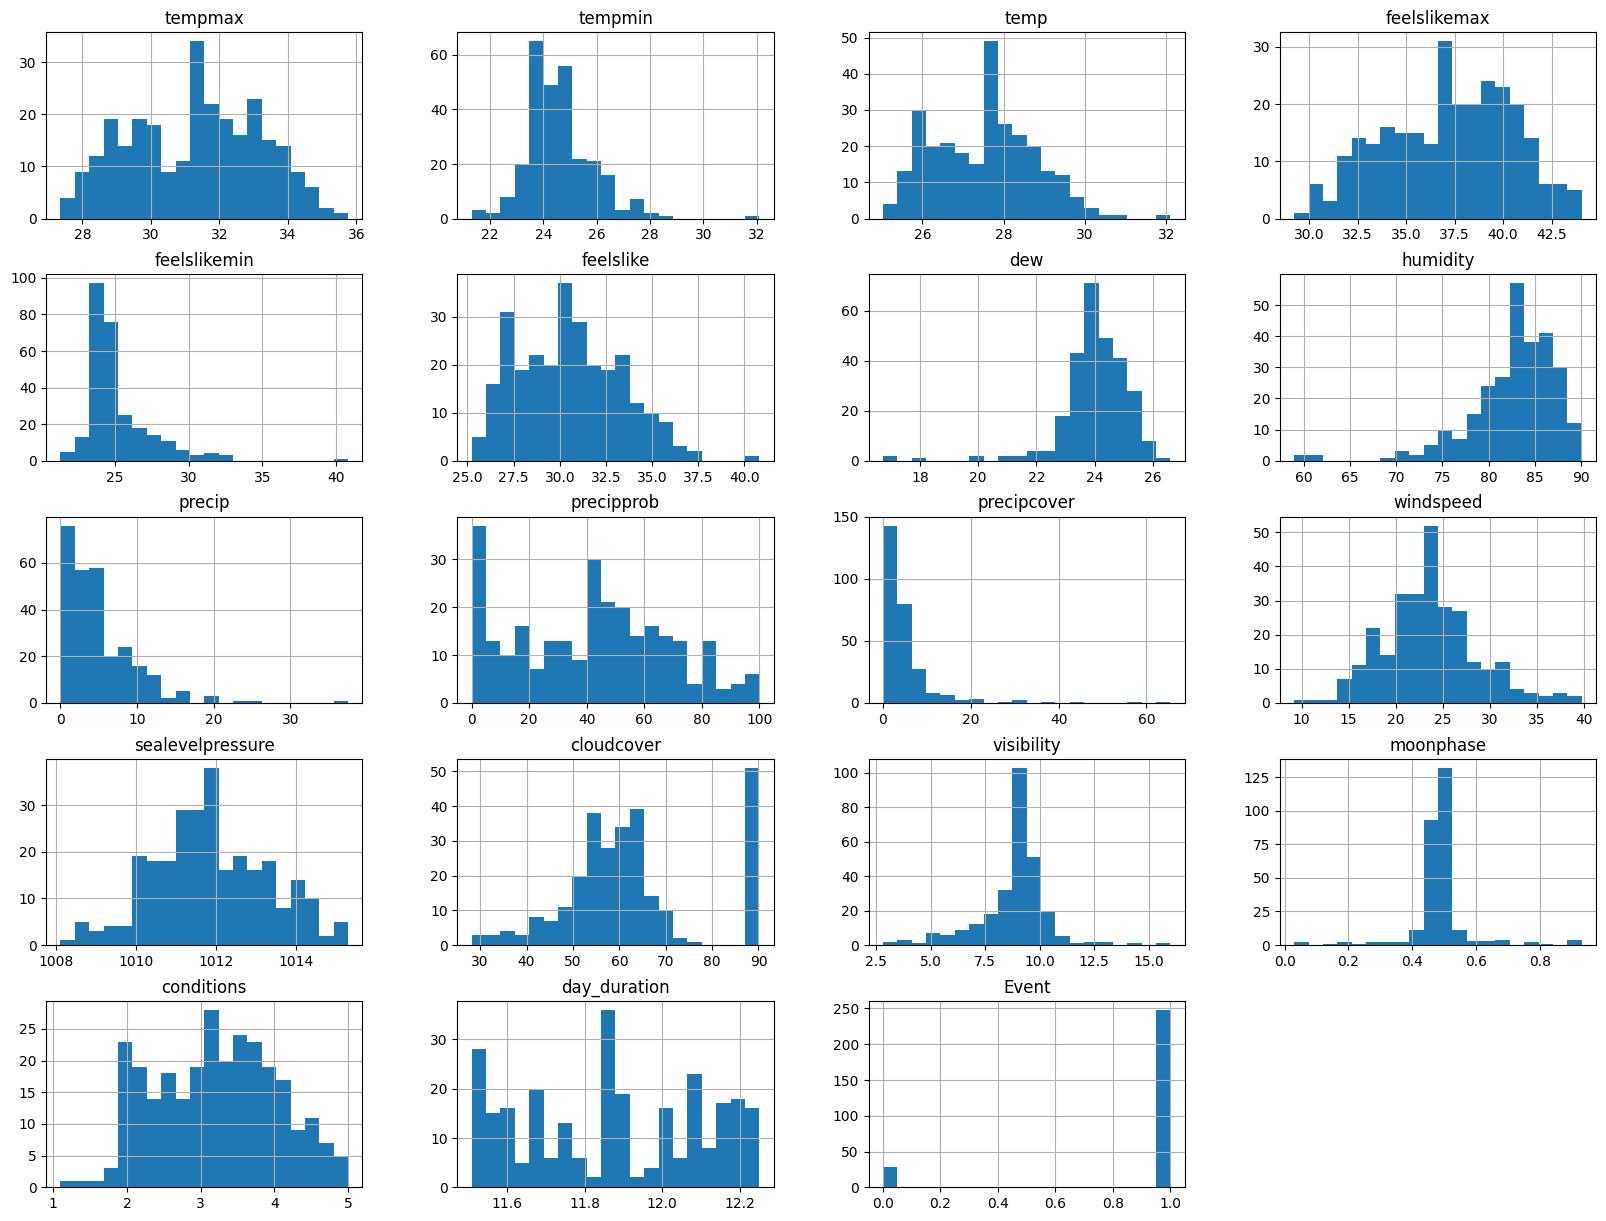

In [169]:
df.hist(bins=20, figsize=(20, 15));

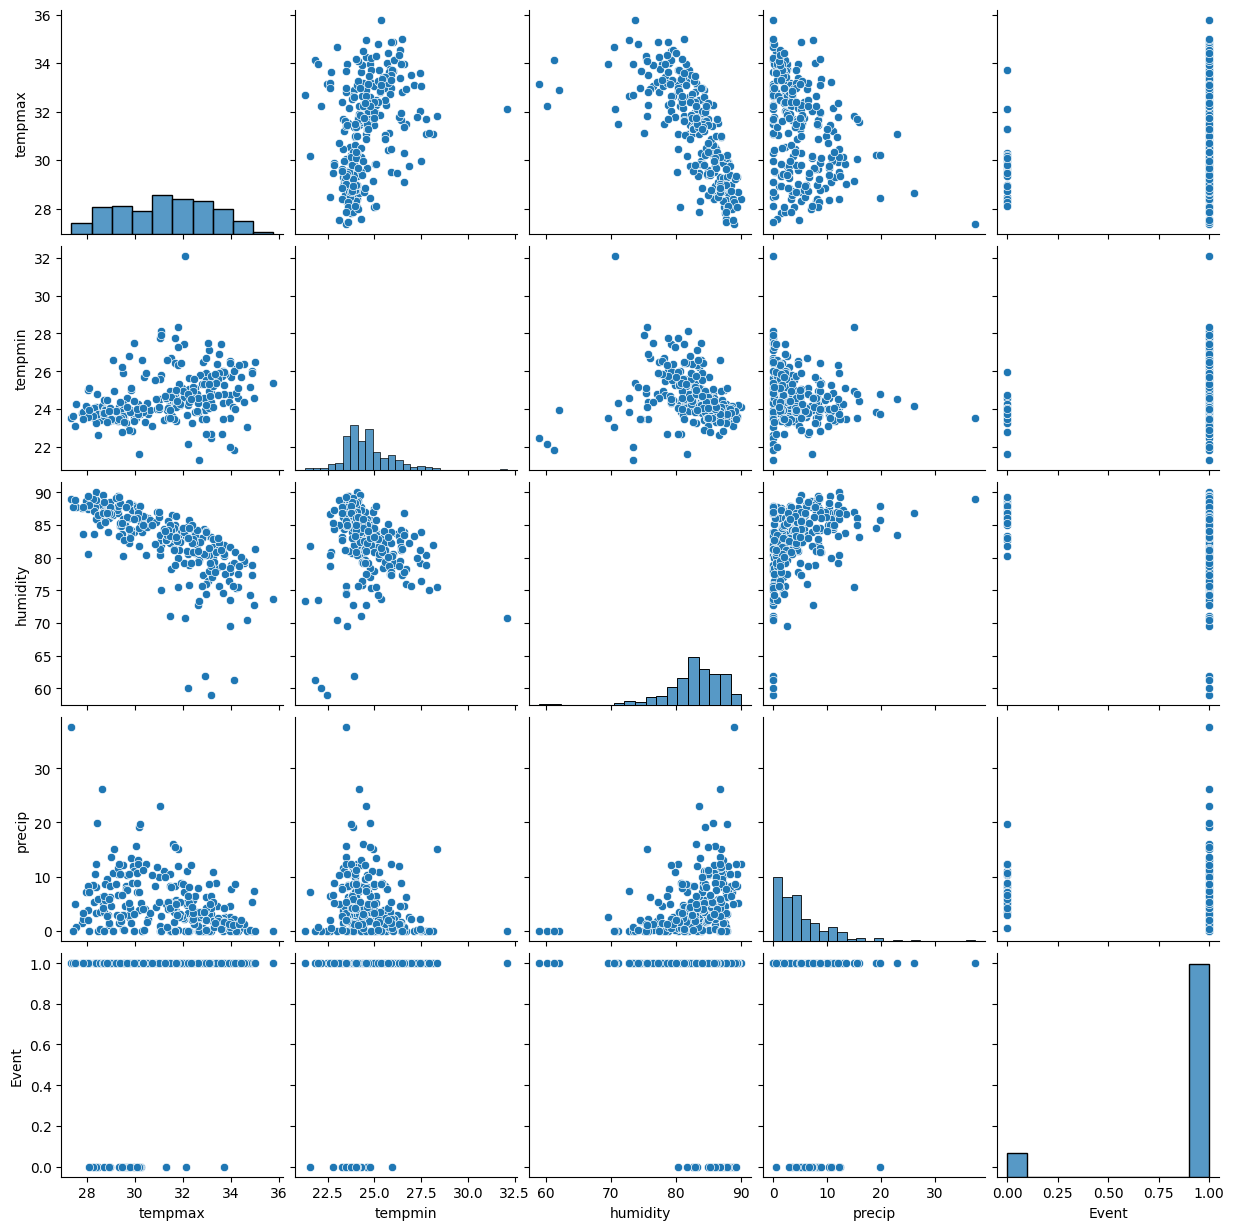

In [170]:
sns.pairplot(df[['tempmax', 'tempmin', 'humidity', 'precip', 'Event']])
plt.show()


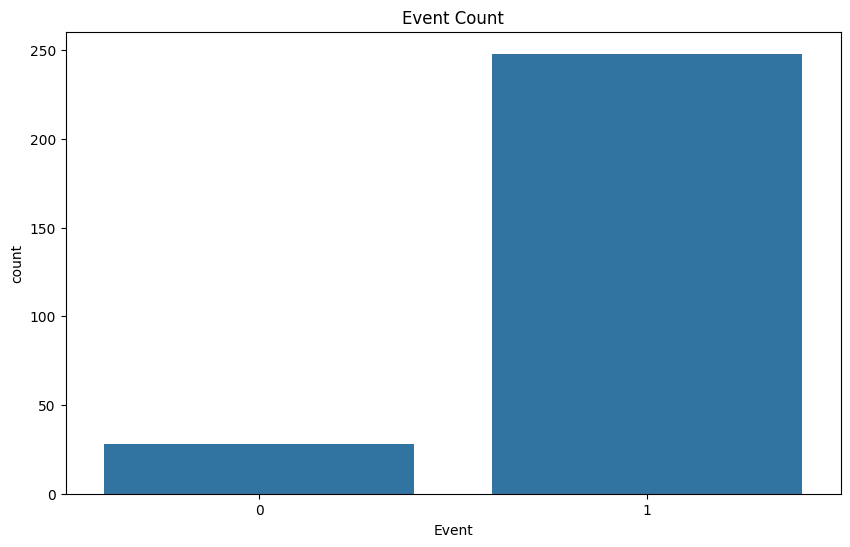

In [171]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Event', data=df)
plt.title('Event Count')
plt.show()

## Model Preparation

In [172]:
X = df.drop(columns=['Event'])
y = df['Event']

In [173]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
base_line = y_test.value_counts(normalize=True).max()
base_line

0.9285714285714286

In [175]:
over_sampler = RandomOverSampler()

x_train, y_train = over_sampler.fit_resample(x_train, y_train)

## Model Training and Evaluation

In [176]:
model = XGBClassifier(n_estimators=1000)

In [177]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [178]:
y_pred = model.predict(x_test)

In [179]:
y_pred = (y_pred>0.5).astype(int)

In [180]:
accuracy_score(y_test, y_pred)

0.9464285714285714

In [181]:
cm = confusion_matrix(y_test, y_pred)

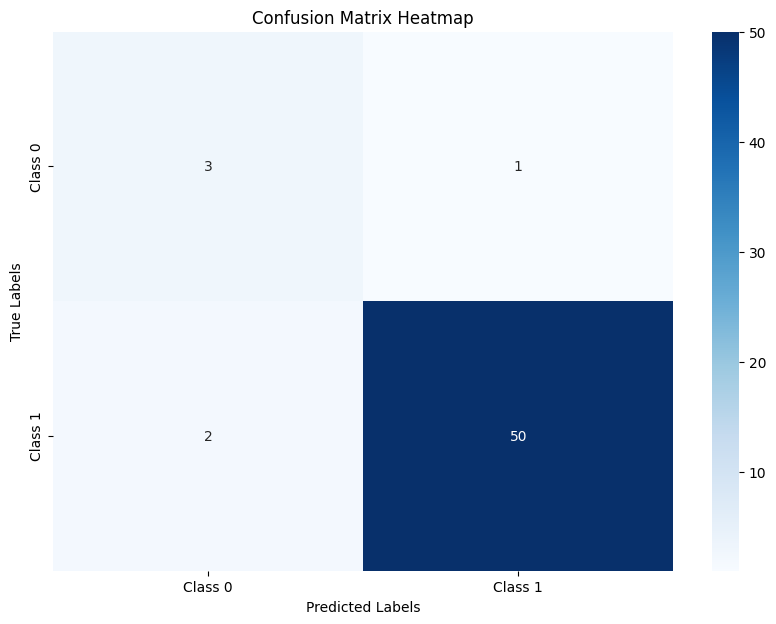

In [182]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],  # Replace with your class names
            yticklabels=['Class 0', 'Class 1'])  # Replace with your class names

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Feature Importance Analysis

In [183]:
importances = model.feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]

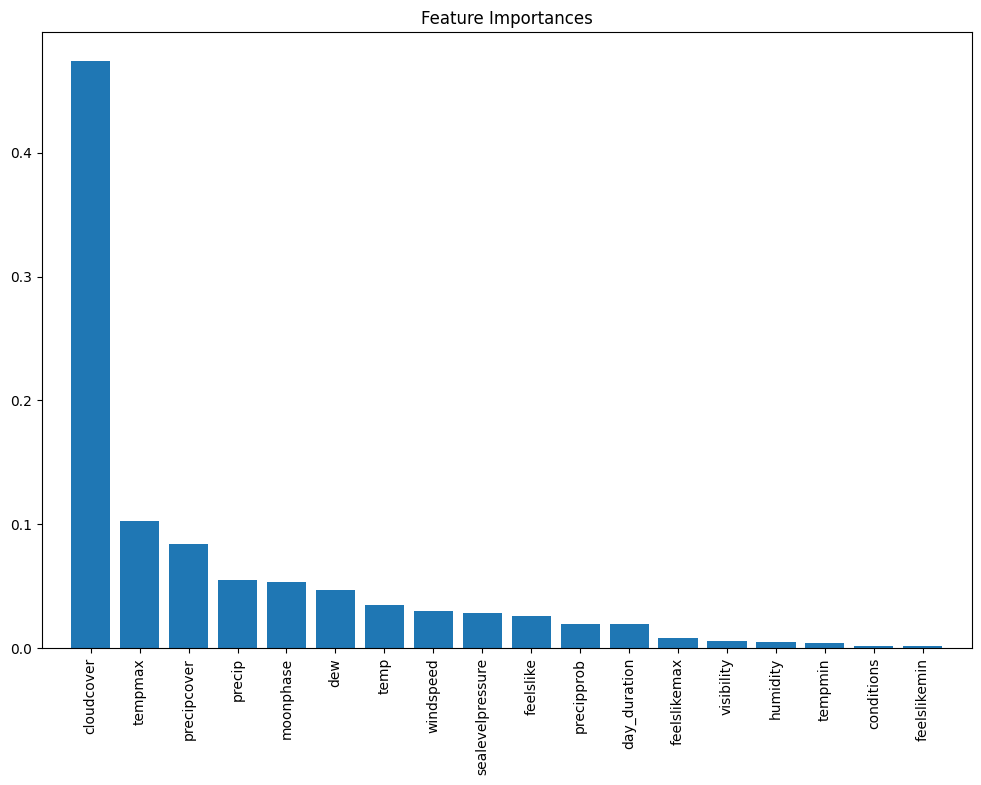

In [184]:
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()